In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import os
from IPython.display import clear_output
from torch import nn
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import joblib

plt.rcParams.update({"font.size": 16})

In [ ]:
file_path = f"{'/'.join(os.getcwd().split('/')[:3])}/year_project"
df = pd.read_csv(f'{file_path}/csv_data/air_weather_data_lite.csv')

### 1. Подготовка данных

#### 1.1 Заполняем пропуски

Для каждого столбца разный алгоритм обработки пропусков<br>
* Строки с пропусками в столбце european_aqi можем удалить
* Строки с глубиной снега заполняем 0, так как пропуски в июле и августе
* Строки со скоростью ветра заполняем медианным значением региона по году и месяцу
* Пропуски в поле income заполняем медианным значением по году по региону
* Пропуски в поле nitrogen_monoxide заполняем медианным значением по году и региону

In [3]:
df.dropna(subset=['european_aqi'], inplace=True)
df['snow_depth'] = df['snow_depth'].fillna(0)

wind_median = df.groupby(['region', 'year', 'month'])['snow_depth'].transform('median')
df['wind_speed_10m'] = df['snow_depth'].fillna(wind_median)

median_income_by_region_year = df.groupby(['region', 'year'])['income'].median().reset_index().rename(columns={'income': 'median_income'})
df = df.merge(median_income_by_region_year, on=['region', 'year'], how='left')
df['income'] = df['income'].fillna(df['median_income'])
df = df.drop(columns=['median_income'])

median_monoxide_by_region_year = df.groupby(['region', 'year'])['nitrogen_monoxide'].median().reset_index().rename(columns={'nitrogen_monoxide': 'nitrogen_monoxide_median'})
df = df.merge(median_monoxide_by_region_year, on=['region', 'year'], how='left')
df['nitrogen_monoxide'] = df['nitrogen_monoxide'].fillna(df['nitrogen_monoxide_median'])
df = df.drop(columns=['nitrogen_monoxide_median'])

#### 1.2 Разделение данных

In [4]:
X = df.drop(['european_aqi', 'city_id'], axis=1)
y = df['european_aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

del df, X, y

#### 1.3 Обработка категориальных признаков

Преобразуем категориальные признаки с помощью LabelEncoder

In [5]:
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

#### 1.4 Разделение тренировочной выборки на тренировочную и валидационную

Разделяем тренировочную выборку на тренировочную и валидационную

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### 2. Обучение моделей

Для начала напишем код для модели, а также будем отображать графики для того, чтобы отслеживать процесс обучения

In [7]:
def plot_mse(train_metrics, val_metrics):
    """
    Plot MSE values while training

    Args:
        train_metrics: sequence of train MSE values
        val_metrics: sequence of validation MSE values
    """
    clear_output()
    plt.figure(figsize=(8, 5))

    plt.plot(range(1, len(train_metrics) + 1), train_metrics, label="Train")
    plt.plot(range(1, len(val_metrics) + 1), val_metrics, label="Validation")

    if max(train_metrics + val_metrics) / min(train_metrics + val_metrics) > 10:
        plt.yscale("log")

    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()


def train_and_validate(
    model,
    optimizer,
    criterion,
    metric,
    train_loader,
    val_loader,
    num_epochs,
    verbose=True,
):
    """
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    """
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_mse(train_metrics, val_metrics)

    if verbose:
        print(f"Validation MSE: {val_metrics[-1]:.3f}")

    return train_metrics[-1], val_metrics[-1]

#### 2.1 Обучаем первую DL модель

Обучаем первую модель<br>
* Кол-во нейронов 512
* Learning rate 1e-3
* batch size 32
* Кол-во эпох 20
* 2 линейных слоя
* Функция активации RELU
* Оптимизация SGD

In [8]:
neurons = 512
lr = 1e-3
batch_size = 32
epochs = 20
input_size = X_train.shape[1]

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val.to_numpy()))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [10]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out.squeeze(-1)

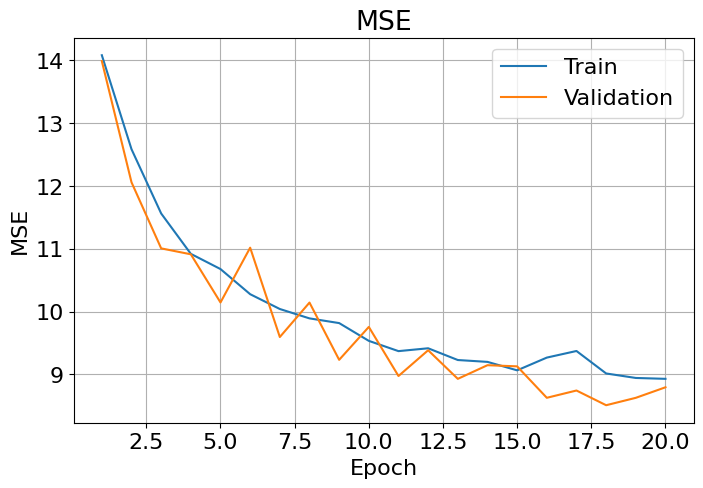

Validation MSE: 8.794


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, neurons).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

metric = lambda preds, targets: mean_squared_error(
    preds.detach().cpu().numpy(),
    targets.detach().cpu().numpy()
)

train_mse, val_mse = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=epochs,
)

Получаем MSE = 8.794

#### 2.2 Оптимизация Adam

Добавляем оптимизацию Adam, learning rate оставляем таким же<br>
* Кол-во нейронов 512
* Learning rate 1e-3
* batch size 32
* Кол-во эпох 20
* 2 линейных слоя
* Функция активации RELU
* Оптимизация Adam

In [16]:
neurons = 512
lr = 1e-3
batch_size = 32
epochs = 20
input_size = X_train.shape[1]

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val.to_numpy()))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out.squeeze(-1)

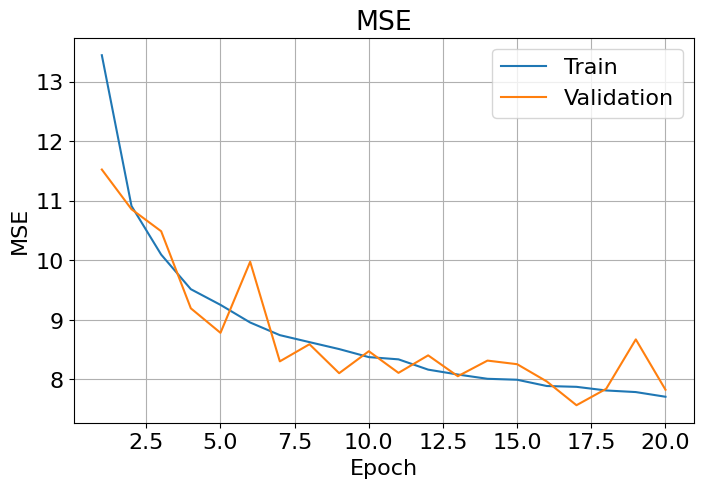

Validation MSE: 7.828


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, neurons).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metric = lambda preds, targets: mean_squared_error(
    preds.detach().cpu().numpy(),
    targets.detach().cpu().numpy()
)

train_mse, val_mse = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=epochs,
)

Получаем MSE = 7.828<br>
Видим, что лучше использовать оптимизацию ADAM<br>
Также видим, что график прыгает, поэтому уменьшим learning rate до 1e-4

#### 2.3 Добавляем больше нейронов и больше слоев

На предыдущих этапах мы использовали 512 нейронов и 2 слоя<br>
Увеличим количество нейронов и количество слоев<br>
* Кол-во нейронов 1024
* Learning rate 1e-4
* batch size 32
* Кол-во эпох 20
* 3 линейных слоя
* Функция активации RELU
* Оптимизация Adam

In [ ]:
neurons = 1024
lr = 1e-4
batch_size = 32
epochs = 20
input_size = X_train.shape[1]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val.to_numpy()))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out.squeeze(-1)

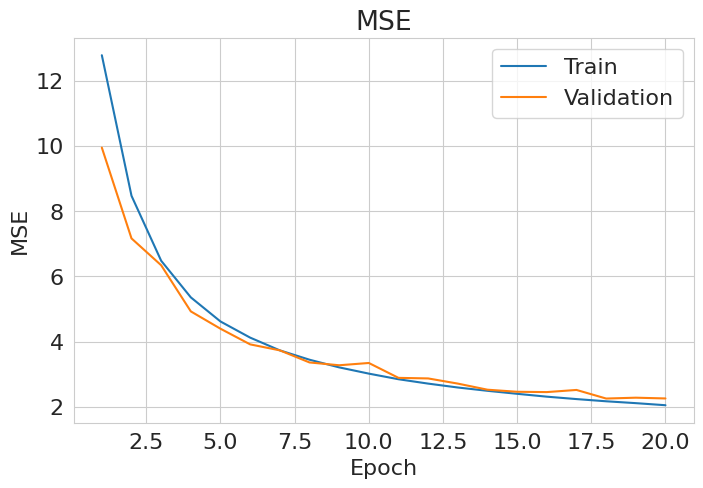

Validation MSE: 2.256


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, neurons).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metric = lambda preds, targets: mean_squared_error(
    preds.detach().cpu().numpy(),
    targets.detach().cpu().numpy()
)

train_mse, val_mse = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=epochs,
)

Увеличение количества нейронов и слоев, а также снижение learning rate позволило значительно уменьшить MSE, а также стабилизировать обучение

#### 2.4 Добавляем dropout

Добавляем dropout<br>
* Кол-во нейронов 1024
* Learning rate 1e-4
* batch size 32
* Кол-во эпох 20
* 3 линейных слоя
* Функция активации RELU
* Оптимизация Adam
* Dropout

In [ ]:
neurons = 1024
lr = 1e-4
batch_size = 32
epochs = 20
input_size = X_train.shape[1]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val.to_numpy()))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dropout2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out.squeeze(-1)

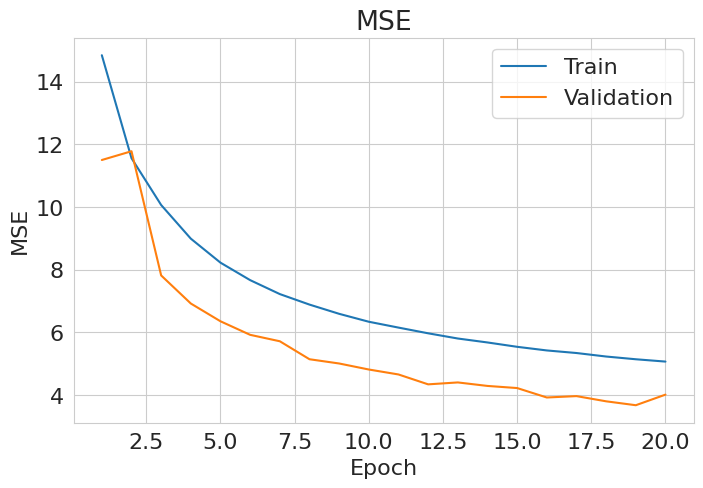

Validation MSE: 4.017


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, neurons).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metric = lambda preds, targets: mean_squared_error(
    preds.detach().cpu().numpy(),
    targets.detach().cpu().numpy()
)

train_mse, val_mse = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=epochs,
)

Добавление dropout не снизило MSE, а увеличило. На дальнейших итерациях dropout применять не будем

#### 2.5 Добавляем больше слоев и нейронов

На предыдущих этапах увеличение слоев и нейронов дало значимое снижение MSE<br>
Добавим больше слоев и нейронов модель<br>
* Кол-во нейронов 2048
* Learning rate 1e-4
* batch size 32
* Кол-во эпох 10
* 5 линейных слоев
* Функция активации RELU
* Оптимизация Adam

In [ ]:
neurons = 2048
lr = 1e-4
batch_size = 32
epochs = 10
input_size = X_train.shape[1]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val.to_numpy()))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out.squeeze(-1)

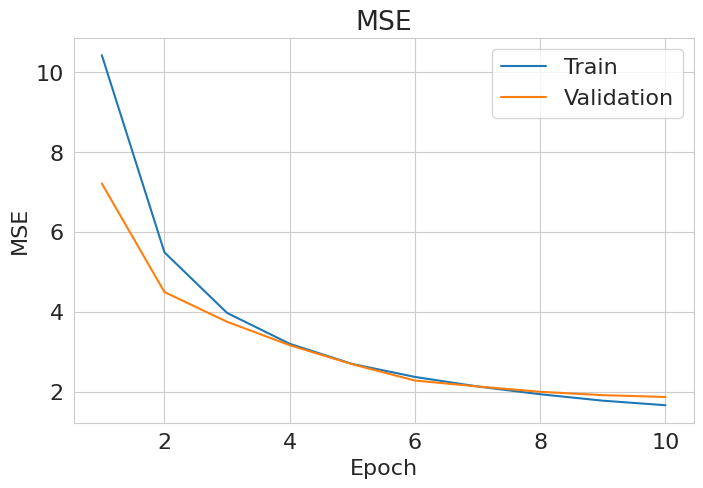

Validation MSE: 1.866


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, neurons).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metric = lambda preds, targets: mean_squared_error(
    preds.detach().cpu().numpy(),
    targets.detach().cpu().numpy()
)

train_mse, val_mse = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=epochs,
)

Видим, что MSE снизилось до 1.866

#### 2.6 Обучаем итоговую модель

Итоговая модель:<br>
* Кол-во нейронов 2048
* Learning rate 1e-4
* batch size 32
* Кол-во эпох 20
* 5 линейных слоев
* Функция активации RELU
* Оптимизация Adam

In [7]:
file_path = f"{'/'.join(os.getcwd().split('/')[:3])}/year_project"
df = pd.read_csv(f'{file_path}/csv_data/air_weather_data_lite.csv')

In [8]:
df.dropna(subset=['european_aqi'], inplace=True)
df['snow_depth'] = df['snow_depth'].fillna(0)

wind_median = df.groupby(['region', 'year', 'month'])['snow_depth'].transform('median')
df['wind_speed_10m'] = df['snow_depth'].fillna(wind_median)

median_income_by_region_year = df.groupby(['region', 'year'])['income'].median().reset_index().rename(columns={'income': 'median_income'})
df = df.merge(median_income_by_region_year, on=['region', 'year'], how='left')
df['income'] = df['income'].fillna(df['median_income'])
df = df.drop(columns=['median_income'])

median_monoxide_by_region_year = df.groupby(['region', 'year'])['nitrogen_monoxide'].median().reset_index().rename(columns={'nitrogen_monoxide': 'nitrogen_monoxide_median'})
df = df.merge(median_monoxide_by_region_year, on=['region', 'year'], how='left')
df['nitrogen_monoxide'] = df['nitrogen_monoxide'].fillna(df['nitrogen_monoxide_median'])
df = df.drop(columns=['nitrogen_monoxide_median'])

In [9]:
X = df.drop(['european_aqi', 'city_id'], axis=1)
y = df['european_aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

del df, X, y

In [ ]:
label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

In [11]:
neurons = 2048
lr = 1e-4
batch_size = 32
epochs = 10
input_size = X_train.shape[1]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()))
test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(y_test.to_numpy()))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [13]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out.squeeze(-1)

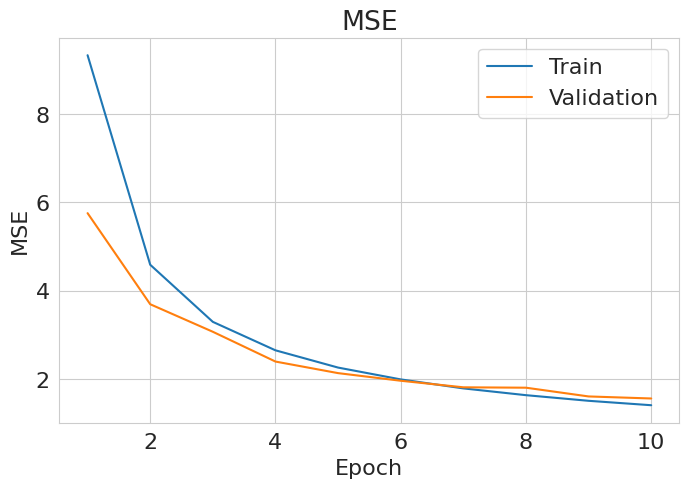

Validation MSE: 1.559


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, neurons).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metric = lambda preds, targets: mean_squared_error(
    preds.detach().cpu().numpy(),
    targets.detach().cpu().numpy()
)

train_mse, test_mse = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=metric,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=epochs,
)

Итоговый результат MSE = 1.559

In [ ]:
torch.save(model.state_dict(), 'dl_model.pth')
joblib.dump(scaler, 'dl_model_scaler.pkl')
joblib.dump(label_encoders, 'dl_model_encoder.pkl')